# **ZPD**
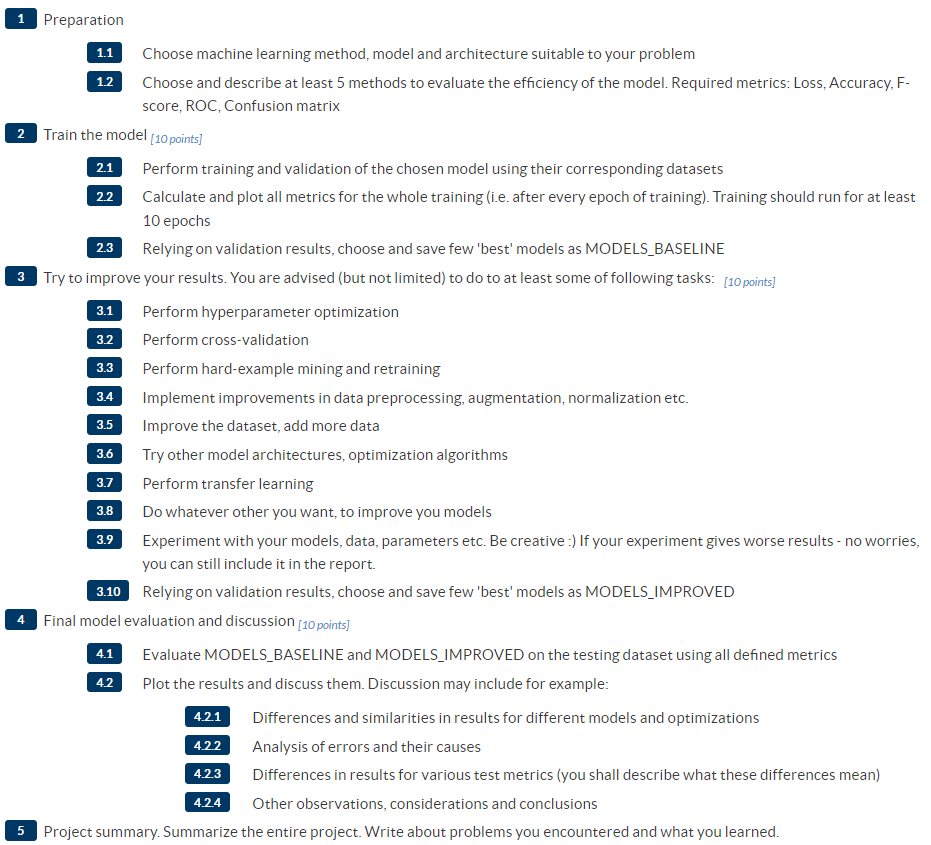

# 1. PREPARATION:
  1. Because our problem is image data classification, we will use transfer learning method and adapt MobileNet V2 developed by Google to our problem. Transfer learning enables us to use pre-trained model (with some data used by creators), and to fine-tune the model to out problem by training it again with data collected by us. It is a supervised learning problem. [https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c]
- [https://www.tensorflow.org/tutorials/images/transfer_learning]

  2. Because our problem is multi-class classification (labels from 0 to 4), possible loss functions are **Multi-Class Cross-Entropy Loss** (which is the default loss function to use for multi-class classification problems), **Sparse Multiclass Cross-Entropy Loss** (used to problems with a large number of labels, which require one hot encoding process; it is performing the same cross-entropy calculation of error, without requiring that the target variable be one hot encoded prior to training) and **Kullback Leibler Divergence Loss** (most commonly used when using models that learn to approximate a more complex function than simply multi-class classification, such as in the case of an autoencoder used for learning a dense feature representation under a model that must reconstruct the original input. In this case, KL divergence loss would be preferred. Nevertheless, it can be used for multi-class classification, in which case it is functionally equivalent to multi-class cross-entropy). 
[https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/]
- Chosen metrics to evaluate the model: 
      - **Loss: Multi-Class Cross-Entropy Loss**. Cross-entropy is the default loss function to use for multi-class classification problems. In this case, it is intended for use with multi-class classification where the target values are in the set {0, 1, 3, …, n}, where each class is assigned a unique integer value. 
      - **Accuracy**. 
      - **F-score**.
      - **ROC**
      - **Confusion matrix**. 


# SZUM
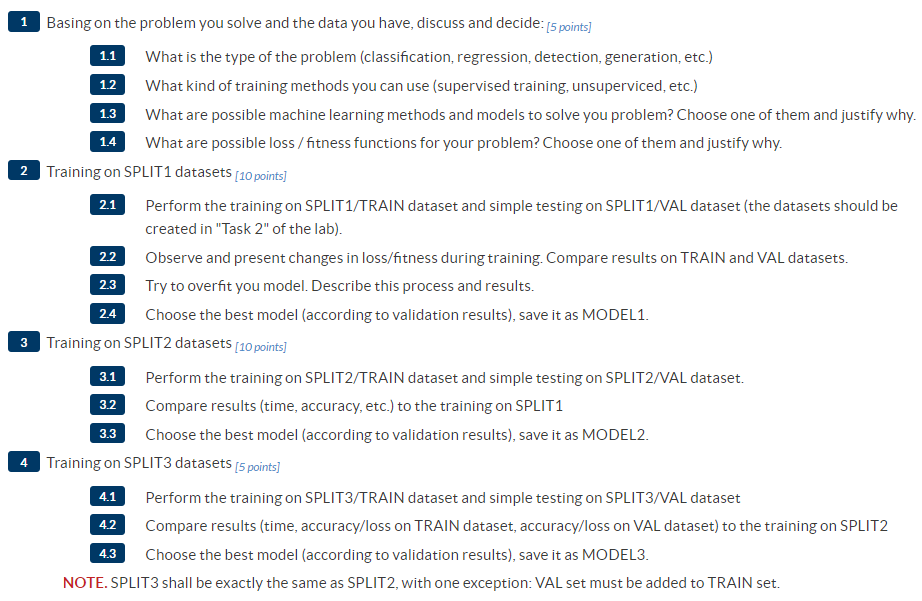

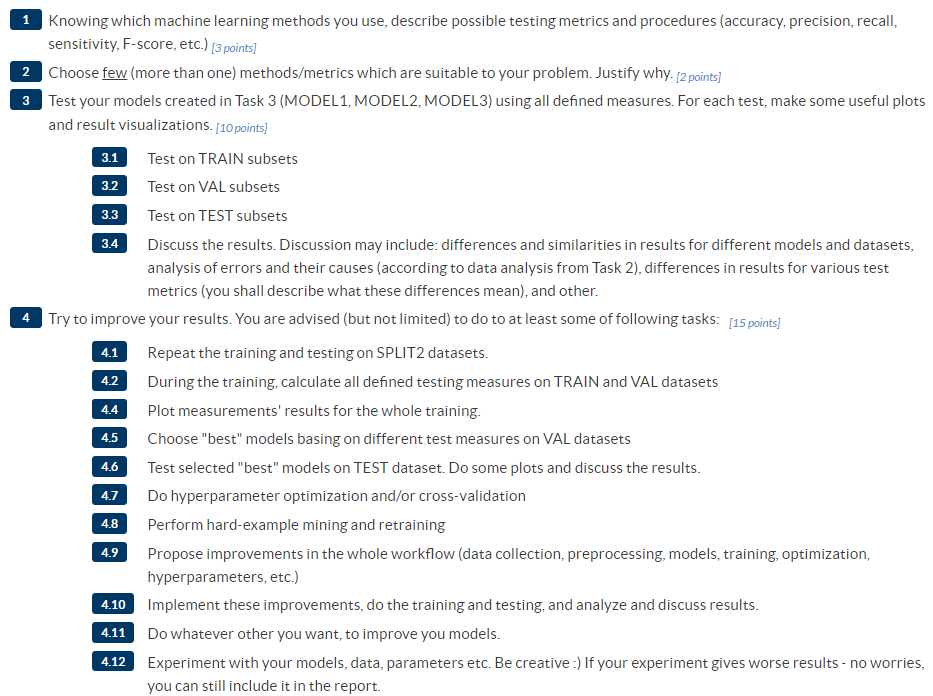

# MODEL TRAINING

## Imports, constants and paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

In [ ]:
root_directory = "/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/"
plots = root_directory + 'plots/'
testset1_path = root_directory + "testset1/"
testset2_path = root_directory + "testset2/"
valset1_path = root_directory + "valset1/"
valset2_path = root_directory + "valset2/"
valset3_path = root_directory + "valset3/"
trainset1_path = root_directory + "trainset1/"
trainset2_path = root_directory + "trainset2/"
trainset3_path = root_directory + "trainset3/"
models_path = root_directory + "models/"
log_file_path = models_path + "logs/"

# FUNCTIONS

In [ ]:
def prepare_datasets(trainset_path, valset_path, log_file_path, model_name, plots_path=plots, batch_size=32, img_size_x=224, img_size_y=224):
  train_dir = trainset_path
  validation_dir = valset_path
  LOG_FILE = log_file_path + model_name + '.txt'

  BATCH_SIZE = batch_size
  IMG_SIZE = (img_size_x, img_size_y)
  # shape of my photos: 256x256
  # shape to choose from: 160x160, 224x224

  #train dataset
  train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                              labels='inferred',
                                                              shuffle=True,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMG_SIZE)
  #val dataset
  validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
  # exemplary calculation
  #                TRAIN  VAL     SUM
  # my calc:       6215   1553    7768
  # keras calc:    6474   1294    7768
  
  class_names = train_dataset.class_names
  plt.figure(figsize=(10, 10))
  for images, labels in train_dataset.take(1):
    for i in range(9):
      if i == 0:
        IMAGES_SHAPE = "images shape: " + str(images[i].numpy().astype("uint8").shape)
        print(IMAGES_SHAPE)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  plt.savefig(plots_path + model_name + "_sample_examples.png")

  nr_train_batches = tf.data.experimental.cardinality(train_dataset)
  nr_val_batches = tf.data.experimental.cardinality(validation_dataset)
  print('Number of train batches: %d' % nr_train_batches)
  print('Number of validation batches: %d' % nr_val_batches)

  # performance options
  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
  validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
  #test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

  with open(LOG_FILE, mode='a', encoding = 'utf-8') as f:
    f.write("MODEL: " + str(model_name) + "\n") 
    # np.array(train_dataset.class_names)
    f.write("class_names: " + str(np.array(class_names)) + "\n") 
    # len(classes)
    f.write("number of classes: " + str(len(class_names)) + "\n") 
    # (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
    f.write("train_dataset.element_spec: " + str(train_dataset.element_spec) + "\n") 
    # type(train_dataset)
    f.write("type(train_dataset): " + str(type(train_dataset)) + "\n") 
    # IMAGES_SHAPE
    f.write("IMAGES_SHAPE after scaling: " + str(IMAGES_SHAPE) + "\n") 
    # batches
    f.write("Number of train batches: " + str(nr_train_batches) + "\n") 
    f.write("Number of validation batches: " + str(nr_val_batches) + "\n") 

  return train_dataset, validation_dataset

In [ ]:
def prepare_model(train_dataset, log_file_path, model_name, img_size_x=224, img_size_y=224):
  LOG_FILE = log_file_path + model_name + '.txt'
  BASE_MODEL_PATH = log_file_path + model_name + '_basemodelsummary.txt'
  IMG_SIZE = (img_size_x, img_size_y)

  IMG_SHAPE = IMG_SIZE + (3,)
  print("IMG_SHAPE: ", IMG_SHAPE)
  # Create the base model from the pre-trained model MobileNet V2
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                 include_top=False,
                                                 weights='imagenet')
  #example batch size
  image_batch, label_batch = next(iter(train_dataset))
  feature_batch = base_model(image_batch)
  print("example batch size", feature_batch.shape)

  # freeze the convolutional base
  base_model.trainable = False

  # Let's save the base model architecture
  with open(BASE_MODEL_PATH, 'a', encoding = 'utf-8') as f:
    base_model.summary(print_fn=lambda x: f.write(x + '\n'))

  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
  # rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # ALTERNATIVE to preprocess_input
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  prediction_layer = tf.keras.layers.Dense(5) # try without , activation='relu'; number of neurons should be = num_classes
  prediction_batch = prediction_layer(feature_batch_average)

  # BUILD MODEL
  inputs = tf.keras.Input(shape=IMG_SHAPE) #(224, 224, 3)
  #x = data_augmentation(inputs) # NO AUGMENTATION!! (offline was used before)
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Let's save the logs
  with open(LOG_FILE, mode='a', encoding = 'utf-8') as f:
    f.write("example batch size: " + str(feature_batch.shape) + "\n") 
    f.write("feature_batch_average.shape: " + str(feature_batch_average.shape) + "\n") # (32, 1280)
    f.write("prediction_batch.shape: " + str(prediction_batch.shape) + "\n") # (32, 5)
  
  return train_dataset, model

In [ ]:
def compile_and_fit_model(train_dataset, validation_dataset, log_file_path, plots_path, model_name, base_learning_rate=0.0001, 
                          epochs=25, early_stopping_epochs=3):
  LOG_FILE = log_file_path + model_name + '.txt'
  COMPILED_MODEL_PATH = log_file_path + model_name + '_compiledmodelsummary.txt'

  # COMPILE MODEL
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #CategoricalCrossentropy(from_logits=True)
                metrics=['accuracy']) #['accuracy', 'f1_score', 'AUC()']
  
  # Let's save the compiled model architecture
  with open(COMPILED_MODEL_PATH, 'a', encoding = 'utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

  # TRAIN THE MODEL
  initial_epochs = epochs
  loss0, accuracy0 = model.evaluate(validation_dataset)
  print("initial loss: {:.2f}".format(loss0))
  print("initial accuracy: {:.2f}".format(accuracy0))

  # set Early Stopping to 3 epochs
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=early_stopping_epochs)
  # FIT THE MODEL
  history = model.fit(train_dataset,
                      epochs=initial_epochs,
                      validation_data=validation_dataset,
                      callbacks=[callback],
                      verbose=1)

  epochs_performed = len(history.history['loss'])
  print("epochs_performed: ", epochs_performed)

  loss1, accuracy1 = model.evaluate(validation_dataset)
  print("loss after training: {:.2f}".format(loss1))
  print("accuracy after training: {:.2f}".format(accuracy1))

  # Let's save the logs
  with open(LOG_FILE, mode='a', encoding = 'utf-8') as f:
    f.write("model.trainable_variables: " + str(model.trainable_variables) + " (two tf.Variable objects, the weights and biases)" + "\n") 
    f.write("initial loss: " + str(loss0) + "\n") 
    f.write("initial accuracy: " + str(accuracy0) + "\n") 
    f.write("learning_rate: " + str(base_learning_rate) + "\n") 
    f.write("max_epochs: " + str(epochs) + "\n") 
    f.write("epochs_performed: " + str(epochs_performed) + "\n") 
    f.write("EarlyStopping (nr_of_epochs): " + str(early_stopping_epochs) + "\n") 
    f.write("loss after training: " + str(loss1) + "\n") 
    f.write("accuracy after training: " + str(accuracy1) + "\n") 

  # PLOT TRAINING RESULTS
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(plots_path + model_name + '_acc_loss.png')
  plt.show()

  return model

# SPLIT3

Found 16437 files belonging to 5 classes.
Found 3286 files belonging to 5 classes.
images shape: (224, 224, 3)
Number of train batches: 514
Number of validation batches: 103
IMG_SHAPE:  (224, 224, 3)
example batch size (32, 7, 7, 1280)
103/103 [==============================] - 228s 2s/step - loss: 1.8018 - accuracy: 0.2304
initial loss: 1.80
initial accuracy: 0.23
Epoch 1/25
514/514 [==============================] - 927s 2s/step - loss: 0.6184 - accuracy: 0.7974 - val_loss: 0.2497 - val_accuracy: 0.9334
Epoch 2/25
514/514 [==============================] - 47s 90ms/step - loss: 0.2204 - accuracy: 0.9387 - val_loss: 0.1672 - val_accuracy: 0.9528
Epoch 3/25
514/514 [==============================] - 47s 91ms/step - loss: 0.1647 - accuracy: 0.9518 - val_loss: 0.1368 - val_accuracy: 0.9595
Epoch 4/25
514/514 [==============================] - 47s 90ms/step - loss: 0.1389 - accuracy: 0.9583 - val_loss: 0.1193 - val_accuracy: 0.9641
Epoch 5/25
514/514 [==============================] - 47s

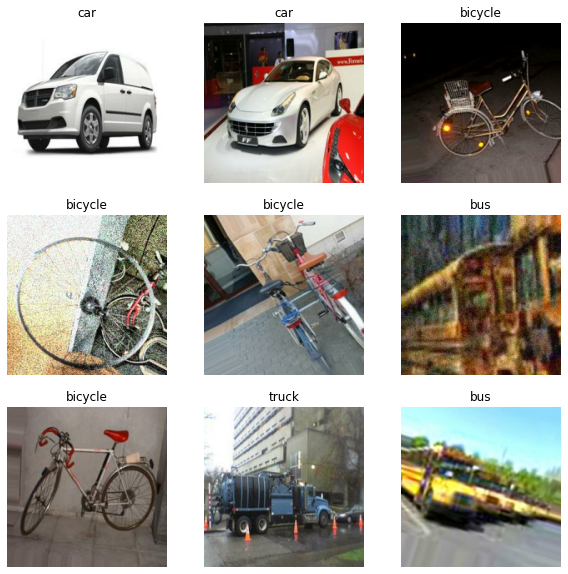

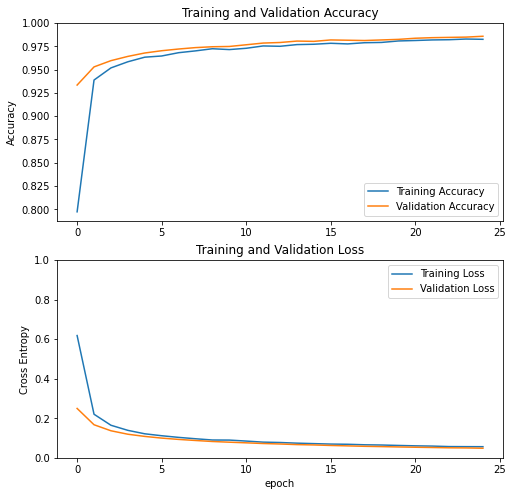

INFO:tensorflow:Assets written to: /content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/models/MODEL3_BASELINE/assets


In [ ]:
MODEL_NAME = 'MODEL3_BASELINE'
trainset_path = trainset3_path
valset_path = valset3_path
train_dataset, validation_dataset = prepare_datasets(trainset_path=trainset_path, valset_path=valset_path, 
                                                    log_file_path=log_file_path, model_name=MODEL_NAME, 
                                                    plots_path=plots, batch_size=32, 
                                                    img_size_x=224, img_size_y=224)
train_dataset, model = prepare_model(train_dataset=train_dataset, log_file_path=log_file_path,
                                     model_name=MODEL_NAME, img_size_x=224, img_size_y=224)
model = compile_and_fit_model(train_dataset=train_dataset, validation_dataset=validation_dataset, log_file_path=log_file_path, 
                              plots_path=plots, model_name=MODEL_NAME, base_learning_rate=0.0001, 
                              epochs=25, early_stopping_epochs=3)
model.save(models_path + MODEL_NAME)

# SPLIT2

Found 13151 files belonging to 5 classes.
Found 3286 files belonging to 5 classes.
images shape: (224, 224, 3)
Number of train batches: 411
Number of validation batches: 103
IMG_SHAPE:  (224, 224, 3)
example batch size (32, 7, 7, 1280)
103/103 [==============================] - 10s 79ms/step - loss: 2.0094 - accuracy: 0.1479
initial loss: 2.01
initial accuracy: 0.15
Epoch 1/25
411/411 [==============================] - 40s 92ms/step - loss: 0.7990 - accuracy: 0.7210 - val_loss: 0.3076 - val_accuracy: 0.9334
Epoch 2/25
411/411 [==============================] - 38s 92ms/step - loss: 0.2647 - accuracy: 0.9273 - val_loss: 0.1918 - val_accuracy: 0.9531
Epoch 3/25
411/411 [==============================] - 38s 91ms/step - loss: 0.1862 - accuracy: 0.9470 - val_loss: 0.1552 - val_accuracy: 0.9601
Epoch 4/25
411/411 [==============================] - 38s 91ms/step - loss: 0.1534 - accuracy: 0.9564 - val_loss: 0.1370 - val_accuracy: 0.9644
Epoch 5/25
411/411 [==============================] - 3

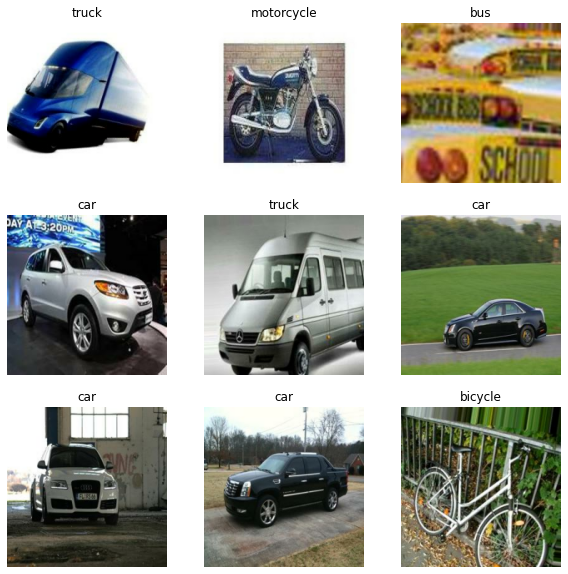

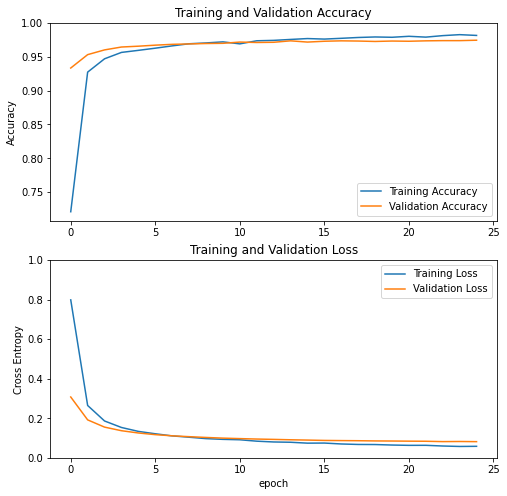

INFO:tensorflow:Assets written to: /content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/models/MODEL2_BASELINE/assets


In [ ]:
MODEL_NAME = 'MODEL2_BASELINE'
train_dataset, validation_dataset = prepare_datasets(trainset_path=trainset2_path, valset_path=valset2_path, 
                                                    log_file_path=log_file_path, model_name=MODEL_NAME, 
                                                    plots_path=plots, batch_size=32, 
                                                    img_size_x=224, img_size_y=224)
train_dataset, model = prepare_model(train_dataset=train_dataset, log_file_path=log_file_path,
                                     model_name=MODEL_NAME, img_size_x=224, img_size_y=224)
model = compile_and_fit_model(train_dataset=train_dataset, validation_dataset=validation_dataset, log_file_path=log_file_path, 
                              plots_path=plots, model_name=MODEL_NAME, base_learning_rate=0.0001, 
                              epochs=25, early_stopping_epochs=3)
model.save(models_path + MODEL_NAME)

# SPLIT1

In [ ]:
train_dir = trainset1_path
validation_dir = valset1_path

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
# shape of my photos: 256x256
# shape to choose from: 160x160, 224x224

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            labels='inferred',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
#                TRAIN  VAL     SUM
# my calc:       6215   1553    7768
# keras calc:    6474   1294    7768

Found 6474 files belonging to 5 classes.


In [ ]:
train_dataset.__doc__

'A `Dataset` that asynchronously prefetches its input.'

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1294 files belonging to 5 classes.


In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
classes = np.array(train_dataset.class_names)
print(classes)
num_classes = len(classes)
print(num_classes)

['bicycle' 'bus' 'car' 'motorcycle' 'truck']
5


In [ ]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
print(images[0].numpy().astype("uint8").shape)

(224, 224, 3)


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


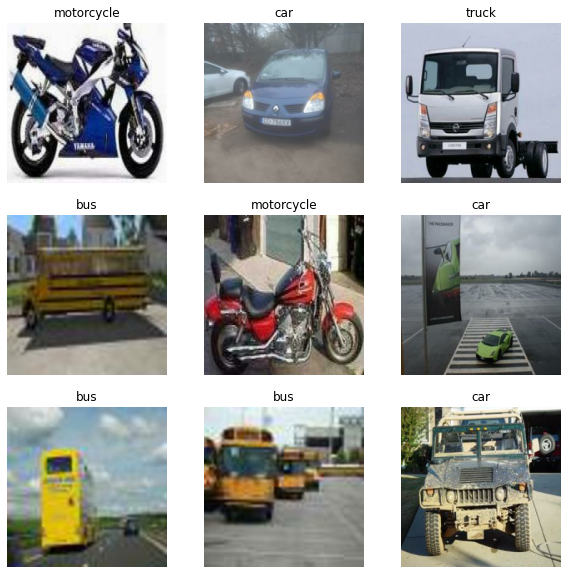

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    print(images[i].numpy().astype("uint8").shape)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of train batches: 203
Number of validation batches: 41


In [ ]:
# performance options
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# alternatively
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SIZE

(224, 224)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(224, 224, 3)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
#IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#example batch size
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
# freeze the convolutional base
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(5) # try without , activation='relu'; number of neurons should be = num_classes
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


build model

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #CategoricalCrossentropy(from_logits=True)
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 5) dtype=float32, numpy=
 array([[ 0.03345748, -0.05428096, -0.02466692,  0.02718699, -0.03981129],
        [-0.00204155,  0.00230704, -0.0890185 ,  0.02171045, -0.02255644],
        [ 0.04133223, -0.01950549, -0.07296289,  0.00617846,  0.04088015],
        ...,
        [ 0.04909162, -0.02042853, -0.01233645,  0.00589201,  0.02957168],
        [-0.03761174, -0.01785781,  0.06838686, -0.12943059,  0.00540103],
        [ 0.02452586,  0.09501706, -0.0399076 , -0.05828138, -0.01729863]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=
 array([ 0.00273122, -0.03280579,  0.01730483, -0.0061292 ,  0.00736522],
       dtype=float32)>]

Train the model

In [ ]:
initial_epochs = 25
loss0, accuracy0 = model.evaluate(validation_dataset)

41/41 [==============================] - 435s 8s/step - loss: 1.5861 - accuracy: 0.3478


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.59
initial accuracy: 0.35


In [ ]:
# set Early Stopping to 3 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[callback],
                    verbose=1)

Epoch 1/25
203/203 [==============================] - 1971s 10s/step - loss: 0.7653 - accuracy: 0.7580 - val_loss: 0.3696 - val_accuracy: 0.9158
Epoch 2/25
203/203 [==============================] - 20s 96ms/step - loss: 0.2996 - accuracy: 0.9222 - val_loss: 0.2096 - val_accuracy: 0.9436
Epoch 3/25
203/203 [==============================] - 21s 100ms/step - loss: 0.1992 - accuracy: 0.9493 - val_loss: 0.1575 - val_accuracy: 0.9560
Epoch 4/25
203/203 [==============================] - 20s 97ms/step - loss: 0.1559 - accuracy: 0.9575 - val_loss: 0.1339 - val_accuracy: 0.9614
Epoch 5/25
203/203 [==============================] - 20s 95ms/step - loss: 0.1356 - accuracy: 0.9634 - val_loss: 0.1209 - val_accuracy: 0.9645
Epoch 6/25
203/203 [==============================] - 19s 93ms/step - loss: 0.1201 - accuracy: 0.9663 - val_loss: 0.1134 - val_accuracy: 0.9637
Epoch 7/25
203/203 [==============================] - 19s 91ms/step - loss: 0.1119 - accuracy: 0.9697 - val_loss: 0.1087 - val_accurac

In [ ]:
len(history.history['loss'])

25

In [ ]:
loss1, accuracy1 = model.evaluate(validation_dataset)
print("loss after training: {:.2f}".format(loss1))
print("accuracy after training: {:.2f}".format(accuracy1))

41/41 [==============================] - 3s 66ms/step - loss: 0.0869 - accuracy: 0.9722
loss after training: 0.09
accuracy after training: 0.97


Learning curves

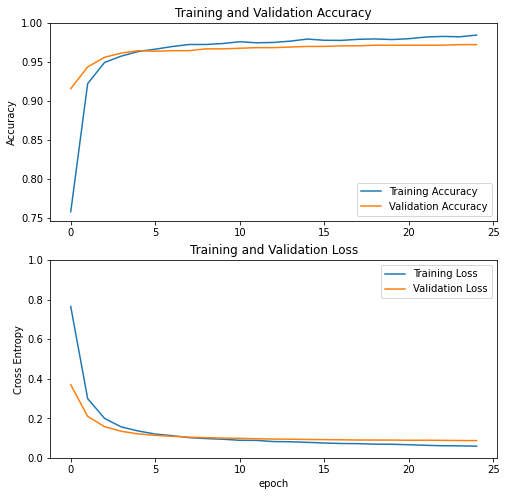

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
# plt.save(plots + 'MODEL1_BASELINE_acc_loss')
plt.show()

Save model [https://www.tensorflow.org/guide/keras/save_and_serialize]

In [ ]:
#model.save(models_path + 'MODEL1_BASELINE')

INFO:tensorflow:Assets written to: /content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/models/MODEL1_BASELINE/assets


# Load model

In [ ]:
from tensorflow import keras
model = keras.models.load_model(models_path + 'MODEL1_BASELINE')

In [ ]:
model